<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

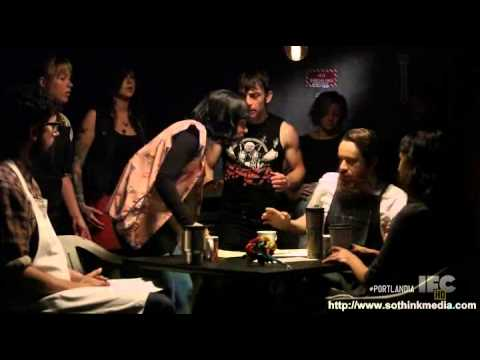

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
"""
Import Statements
"""

# Base
from collections import Counter
import re
 
import pandas as pd

print('base loaded')

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

print('plotting loaded')

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

print('NLP libraries loaded')

nlp = spacy.load("en_core_web_lg")

print('en_core_web_lg loaded')

base loaded
plotting loaded
NLP libraries loaded
en_core_web_lg loaded


In [3]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)

shops['date'] = shops['full_review_text'].apply(lambda x : x.split(maxsplit=1)[0])
shops['full_review_text'] = shops['full_review_text'].apply(lambda x : x.split(maxsplit=1)[1])
shops['star_rating'] = shops['star_rating'].apply(lambda x : int(float(x.split()[0])))
shops['full_review_text'] = shops['full_review_text'].apply(lambda x : x.lower())

shops.head()

,coffee_shop_name,full_review_text,star_rating,date
0,The Factory - Cafe With a Soul,1 check-in love love loved the atmosphere! eve...,5,11/25/2016
1,The Factory - Cafe With a Soul,"listed in date night: austin, ambiance in aust...",4,12/2/2016
2,The Factory - Cafe With a Soul,1 check-in listed in brunch spots i loved the ...,4,11/30/2016
3,The Factory - Cafe With a Soul,very cool decor! good drinks nice seating how...,2,11/25/2016
4,The Factory - Cafe With a Soul,1 check-in they are located within the northcr...,4,12/3/2016


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [5]:
nlp = spacy.load("en_core_web_lg")

STOP_WORDS = nlp.Defaults.stop_words.union(['coffee',' ', 'i', 'it', "it's", 'it.', 'the', 'this', 'place'])

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [6]:
# Tokenizer Pipe

def tokenize(dataframe):
    tokens = []
    """ Update those tokens w/o stopwords"""
    for doc in tokenizer.pipe(dataframe['full_review_text'], batch_size=500):

        doc_tokens = []

        for token in doc:
            if token.text.lower() not in STOP_WORDS:
                doc_tokens.append(token.text.lower())

        tokens.append(doc_tokens)
        
    return tokens

In [7]:
wc = count(tokenize(shops))

In [8]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
127,great,2438,3250,1.0,0.008575,0.008575,0.320116
190,like,2034,2902,2.0,0.007657,0.016232,0.267069
163,good,2084,2779,3.0,0.007332,0.023564,0.273634
1,1,1998,2035,4.0,0.005369,0.028934,0.262342
40,check-in,1957,1961,5.0,0.005174,0.034108,0.256959


In [9]:
print('Total Number of tokens: {}'.format(len(wc['word'])))

Total Number of tokens: 38923


In [10]:
rates = [shops.loc[shops['star_rating'] == x] for x in range(1,6)]
counts = []

for x in rates:
    counts.append(count(tokenize(x)))

In [11]:
for x,y in zip(counts, range(1,6)):
    string = "Word counts for rating {}:{}".format(y,len(x))
    print(string)

Word counts for rating 1:5392
Word counts for rating 2:7417
Word counts for rating 3:9789
Word counts for rating 4:19645
Word counts for rating 5:23346


In [12]:
bad_shops = shops.loc[shops['star_rating'] <= 3]
good_shops = shops.loc[shops['star_rating'] > 3]

In [13]:
bad_counts = count(tokenize(bad_shops))
good_counts = count(tokenize(good_shops))

In [14]:
bad_counts.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
36,like,548,834,1.0,0.009918,0.009918,0.371274
7,good,441,599,2.0,0.007123,0.017041,0.298780
209,don't,340,430,3.0,0.005113,0.022154,0.230352
55,i'm,305,422,4.0,0.005018,0.027173,0.206640
122,1,377,386,5.0,0.004590,0.031763,0.255420


In [15]:
good_counts.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
127,great,2174,2902,1.0,0.009840,0.009840,0.354072
261,good,1643,2180,2.0,0.007392,0.017232,0.267590
217,like,1486,2068,3.0,0.007012,0.024244,0.242020
1,1,1621,1649,4.0,0.005591,0.029836,0.264007
12,love,1263,1604,5.0,0.005439,0.035275,0.205700


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [16]:
good_head = good_counts.head()
good_tail = good_counts.tail()
bad_head = bad_counts.head()
bad_tail = bad_counts.tail()

In [20]:
heads = good_head.append(bad_head)

In [21]:
heads

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
127,great,2174,2902,1.0,0.009840,0.009840,0.354072
261,good,1643,2180,2.0,0.007392,0.017232,0.267590
217,like,1486,2068,3.0,0.007012,0.024244,0.242020
1,1,1621,1649,4.0,0.005591,0.029836,0.264007
12,love,1263,1604,5.0,0.005439,0.035275,0.205700
36,like,548,834,1.0,0.009918,0.009918,0.371274
7,good,441,599,2.0,0.007123,0.017041,0.298780
209,don't,340,430,3.0,0.005113,0.022154,0.230352
55,i'm,305,422,4.0,0.005018,0.027173,0.206640
122,1,377,386,5.0,0.004590,0.031763,0.255420


In [18]:
diff = b

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
36,like,548,834,1.0,0.009918,0.009918,0.371274
7,good,441,599,2.0,0.007123,0.017041,0.298780
209,don't,340,430,3.0,0.005113,0.022154,0.230352
55,i'm,305,422,4.0,0.005018,0.027173,0.206640
122,1,377,386,5.0,0.004590,0.031763,0.255420


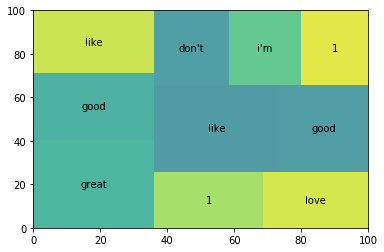

In [22]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=heads['pct_total'], label=heads['word'], alpha=.8 )

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

